In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import resample

#%matplotlib notebook #interactable 3d plots

#functions from task description
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#from lecture notes on Ridge/Lasso regression
def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

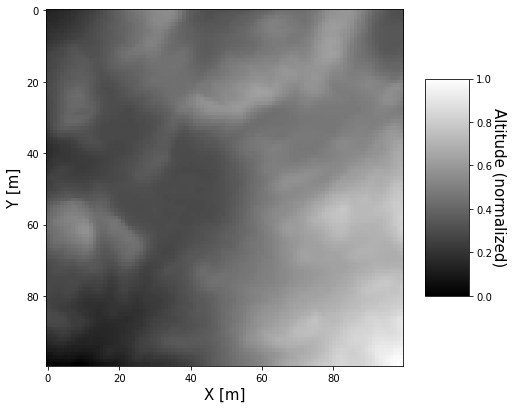

In [78]:
from imageio import imread
from numpy.random import normal, uniform
import warnings
warnings.filterwarnings('ignore')

# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

N = 100 #running a larger section (N = 1000) tends to kill the kernel
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_, y_ = np.meshgrid(x,y)

z = terrain
#normalize, so we can compare with Franke
z = (z - np.min(z))/(np.max(z) - np.min(z))  

# Show the terrain
fig, ax = plt.subplots(figsize = (8, 8))

ter = plt.imshow(z, cmap='gray')
plt.xlabel('X [m]', fontsize = 15)
plt.ylabel('Y [m]', fontsize = 15)
cbar = plt.colorbar(ter, cmap = 'gray', shrink=0.5, aspect=5)
cbar.set_label('Altitude (normalized)', fontsize = 15, rotation=270, labelpad=15)
plt.show()

In [64]:
### MSE and R2 of OLS/RIDGE/LASSO as function of polynomial degree n
### This block takes some time to run (increase N/n/nlambdas at own risk)

n = 10 # Maximum polynomial degree
#matrices; rows are different regression methods, columns degrees n
MSE_train = np.zeros((3, n)) 
R2_train = np.zeros((3, n))
MSE_test = np.zeros((3, n))
R2_test = np.zeros((3, n))
#Index i in [i, n]: 0 OLS, 1 Ridge, 2 Lasso


N_ = np.array([b+1 for b in range(n)])
nlambdas = 25 #number of lambdas for ridge/lasso
lambdas = np.logspace(-15, 15, nlambdas)

#Perform OLS analysis for every degree
#Every degree: determine ideal lambda for ridge/lasso; analyze that model

for i in range(0, n): #variables marked to avoid confusion with older
    X_ = create_X(x_, y_, i+1)
    # Same divide every iteration (scale the split?)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, np.ravel(z), test_size=0.2, random_state = 40)
    # Scaling
    #X_train_ = (X_train_ - np.mean(X_train_))
    #X_test_ = (X_test_ - np.mean(X_train_))
    #z_train_ = z_train_ - np.mean(z_train_)
    
    # OLS
    beta_ = np.linalg.pinv(X_train_.T @ X_train_) @ X_train_.T @ z_train_
    ztilde_ = X_train_ @ beta_ #+ np.mean(z_train_)
    zpredict_ = X_test_ @ beta_ #+ np.mean(z_train_)
    MSE_train[0, i] = (MSE(z_train_, ztilde_))
    R2_train[0, i] = (R2(z_train_, ztilde_))
    MSE_test[0, i] = (MSE(z_test_, zpredict_))
    R2_test[0, i] = (R2(z_test_, zpredict_))
    
    # RIDGE/LASSO
    MSERidgePredict = np.zeros(nlambdas) # Stores lambdas, save the optimal one every degree
    MSELassoPredict = np.zeros(nlambdas)
    
    I = np.eye(len(X_train_[1]))
    for j in range(nlambdas): #from Dom's code
        RidgeBeta = np.linalg.inv(X_train_.T @ X_train_ + lambdas[j]*I) @ X_train_.T @ z_train_
        zpredictRidge = X_test_ @ RidgeBeta
        MSERidgePredict[j] = MSE(np.ravel(z_test_), zpredictRidge)
        
        RegLasso = Lasso(lambdas[j]) #lasso lines borrowed from lect notes (4.10)
        RegLasso.fit(X_train_, z_train_)
        zpredictLasso = RegLasso.predict(X_test_) 
        MSELassoPredict[j] = MSE(np.ravel(z_test_), zpredictLasso)
        
    # Save ideal lambdas
    RidgeLambda = lambdas[int(np.argmin(MSERidgePredict))]
    RidgeBeta = np.linalg.inv(X_train_.T @ X_train_ + RidgeLambda*I) @ X_train_.T @ z_train_
    ztildeRidge = X_train_ @ RidgeBeta
    zpredictRidge = X_test_ @ RidgeBeta
    MSE_train[1, i] = (MSE(z_train_, ztildeRidge))
    R2_train[1, i] = (R2(z_train_, ztildeRidge))
    MSE_test[1, i] = (MSE(z_test_, zpredictRidge))
    R2_test[1, i] = (R2(z_test_, zpredictRidge))
    
    LassoLambda = lambdas[int(np.argmin(MSELassoPredict))]
    RegLasso = Lasso(LassoLambda) #lasso lines borrowed from lect notes (4.10)
    RegLasso.fit(X_train_, z_train_)
    zpredictLasso = RegLasso.predict(X_test_)
    ztildeLasso = RegLasso.predict(X_train_) # ?
    MSE_train[2, i] = MSE(z_train_, ztildeLasso)
    R2_train[2, i] = R2(z_train_, ztildeLasso)
    MSE_test[2, i] = MSE(np.ravel(z_test_), zpredictLasso)
    R2_test[2, i] = R2(np.ravel(z_test_), zpredictLasso)

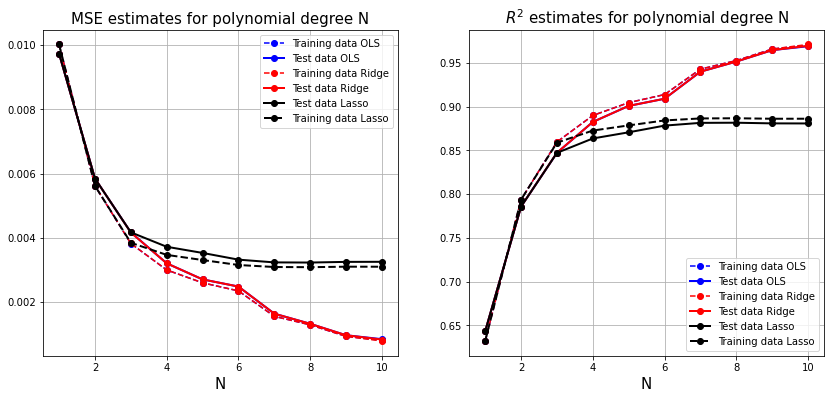

Difference R^2 (Ridge - OLS): 
 [ 0.00000000e+00 -3.61983627e-07 -7.63257257e-05  0.00000000e+00
 -1.11022302e-16 -5.37912265e-07  7.77156117e-16 -2.97333269e-11
  1.56892634e-06  7.02866359e-04]


In [67]:
# Plotting MSE and R2 as function of polynomial degree

fig = plt.figure(figsize = (14, 6)) 
plt.subplot(1, 2, 1)
plt.title('MSE estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, MSE_train[0, :], 'b--', marker = 'o', label = 'Training data OLS')
plt.plot(N_, MSE_test[0, :], 'b', marker = 'o', label = 'Test data OLS', linewidth = 2)

plt.plot(N_, MSE_train[1, :], 'r--', marker = 'o', label = 'Training data Ridge')
plt.plot(N_, MSE_test[1, :], 'r', marker = 'o', label = 'Test data Ridge', linewidth = 2)

plt.plot(N_, MSE_test[2, :], 'k', marker = 'o', label = 'Test data Lasso', linewidth = 2)
plt.plot(N_, MSE_train[2, :], 'k--', marker = 'o', label = 'Training data Lasso', linewidth = 2)

plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend()

plt.subplot(1, 2, 2)
plt.title('$R^2$ estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, R2_train[0, :], 'b--', marker = 'o', label = 'Training data OLS')
plt.plot(N_, R2_test[0, :], 'b', marker = 'o', label = 'Test data OLS', linewidth = 2)

plt.plot(N_, R2_train[1, :], 'r--', marker = 'o', label = 'Training data Ridge')
plt.plot(N_, R2_test[1, :], 'r', marker = 'o', label = 'Test data Ridge', linewidth = 2)

plt.plot(N_, R2_test[2, :], 'k', marker = 'o', label = 'Test data Lasso', linewidth = 2)
plt.plot(N_, R2_train[2, :], 'k--', marker = 'o', label = 'Training data Lasso', linewidth = 2)

plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

print('Difference R^2 (Ridge - OLS): \n', (R2_train[1, :]) - R2_train[0, :])

The difference between OLS and Ridge regression is small, but it is sometimes apparent that Ridge makes small improvements on the OLS approximation.

In [75]:
#####################################################################################################
### cross-validation (this could be implemented in the previous loop)
### perform on OLS, ridge, lasso model to evaluate quality

### This block takes even longer to run, increase variables at own risk

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k, shuffle = True)

# Perform the cross-validation to estimate MSE
maxdegree = n
scores_KFold = np.zeros((maxdegree, k))
scores_KFold_R = np.zeros((maxdegree, k))
scores_KFold_L = np.zeros((maxdegree, k))
model = LinearRegression()

N_ = np.array([b+1 for b in range(maxdegree)])
for i in range(maxdegree):
    X_ = create_X(x_, y_, i+1)
    j = 0
    for train_inds, test_inds in kfold.split(X_):
        Xtrain = X_[train_inds]
        ztrain = z.ravel()[train_inds]

        Xtest = X_[test_inds]
        ztest = z.ravel()[test_inds]
        
        # OLS
        zpred = model.fit(Xtrain, ztrain).predict(Xtest).ravel()
        scores_KFold[i, j] = np.mean((zpred.flatten() - ztest.flatten())**2)
        
        # Ridge/Lasso
        MSERidgePredict_ = np.zeros(nlambdas) # Stores lambdas, save the optimal one every degree
        MSELassoPredict_ = np.zeros(nlambdas)
        I = np.eye(len(Xtrain[1]))
        
        for k in range(nlambdas): #from Dom's code
            RidgeBeta = np.linalg.inv(Xtrain.T @ Xtrain + lambdas[k]*I) @ Xtrain.T @ ztrain
            zpredRidge = Xtest @ RidgeBeta
            MSERidgePredict_[k] = MSE(np.ravel(ztest), zpredRidge)

            RegLasso = Lasso(lambdas[k]) #lasso lines borrowed from lect notes (4.10)
            RegLasso.fit(Xtrain, ztrain)
            zpredLasso = RegLasso.predict(Xtest) 
            MSELassoPredict_[k] = MSE(np.ravel(ztest), zpredLasso)
        
        RidgeLambda = lambdas[int(np.argmin(MSERidgePredict_))]
        RidgeBeta = np.linalg.inv(Xtrain.T @ Xtrain + RidgeLambda*I) @ Xtrain.T @ ztrain
        zpredRidge = Xtest @ RidgeBeta
        scores_KFold_R[i, j] = np.mean((zpredRidge.flatten() - ztest.flatten())**2)
        
        LassoLambda = lambdas[int(np.argmin(MSELassoPredict_))]
        RegLasso = Lasso(LassoLambda) #lasso lines borrowed from lect notes (4.10)
        RegLasso.fit(Xtrain, ztrain)
        zpredLasso = RegLasso.predict(Xtest)
        scores_KFold_L[i, j] = np.mean((zpredLasso.flatten() - ztest.flatten())**2)
        j += 1

estimated_mse_KFold = np.mean(scores_KFold, axis = 1)
estimated_mse_KFold_R = np.mean(scores_KFold_R, axis = 1)
estimated_mse_KFold_L = np.mean(scores_KFold_L, axis = 1)

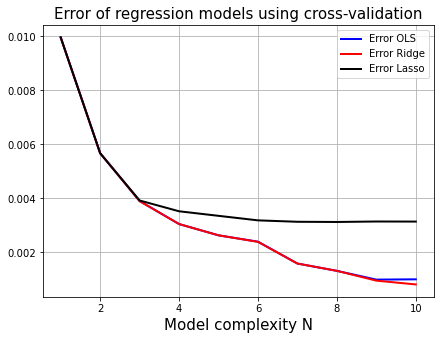

In [77]:
fig = plt.figure(figsize = (7, 5)) 
plt.title('Error of regression models using cross-validation', fontsize = 15)
plt.plot(N_, estimated_mse_KFold, 'b', label = 'Error OLS', linewidth = 2)
plt.plot(N_, estimated_mse_KFold_R, 'r', label = 'Error Ridge', linewidth = 2)
plt.plot(N_, estimated_mse_KFold_L, 'k', label = 'Error Lasso', linewidth = 2)
plt.xlabel('Model complexity N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

Even after implementing cross-validation resampling the Lasso regression struggles (may be effect of insufficient data scaling), and in this case we see a significant improvement in the Ridge approximation at n = 10 compared to the OLS estimate.